<a href="https://colab.research.google.com/github/dustoff06/NLP_Class/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 2.4878
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 2.4634
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 2.4378
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 2.4085
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 2.3718
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 2.3224
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 2.2504
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 2.1385
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1.9670
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 1.8345
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 1.7846
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 1.6270
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 1.5263
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 1.4104
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 1.2738
Epoch 16/50
1/1 ━━━━━━

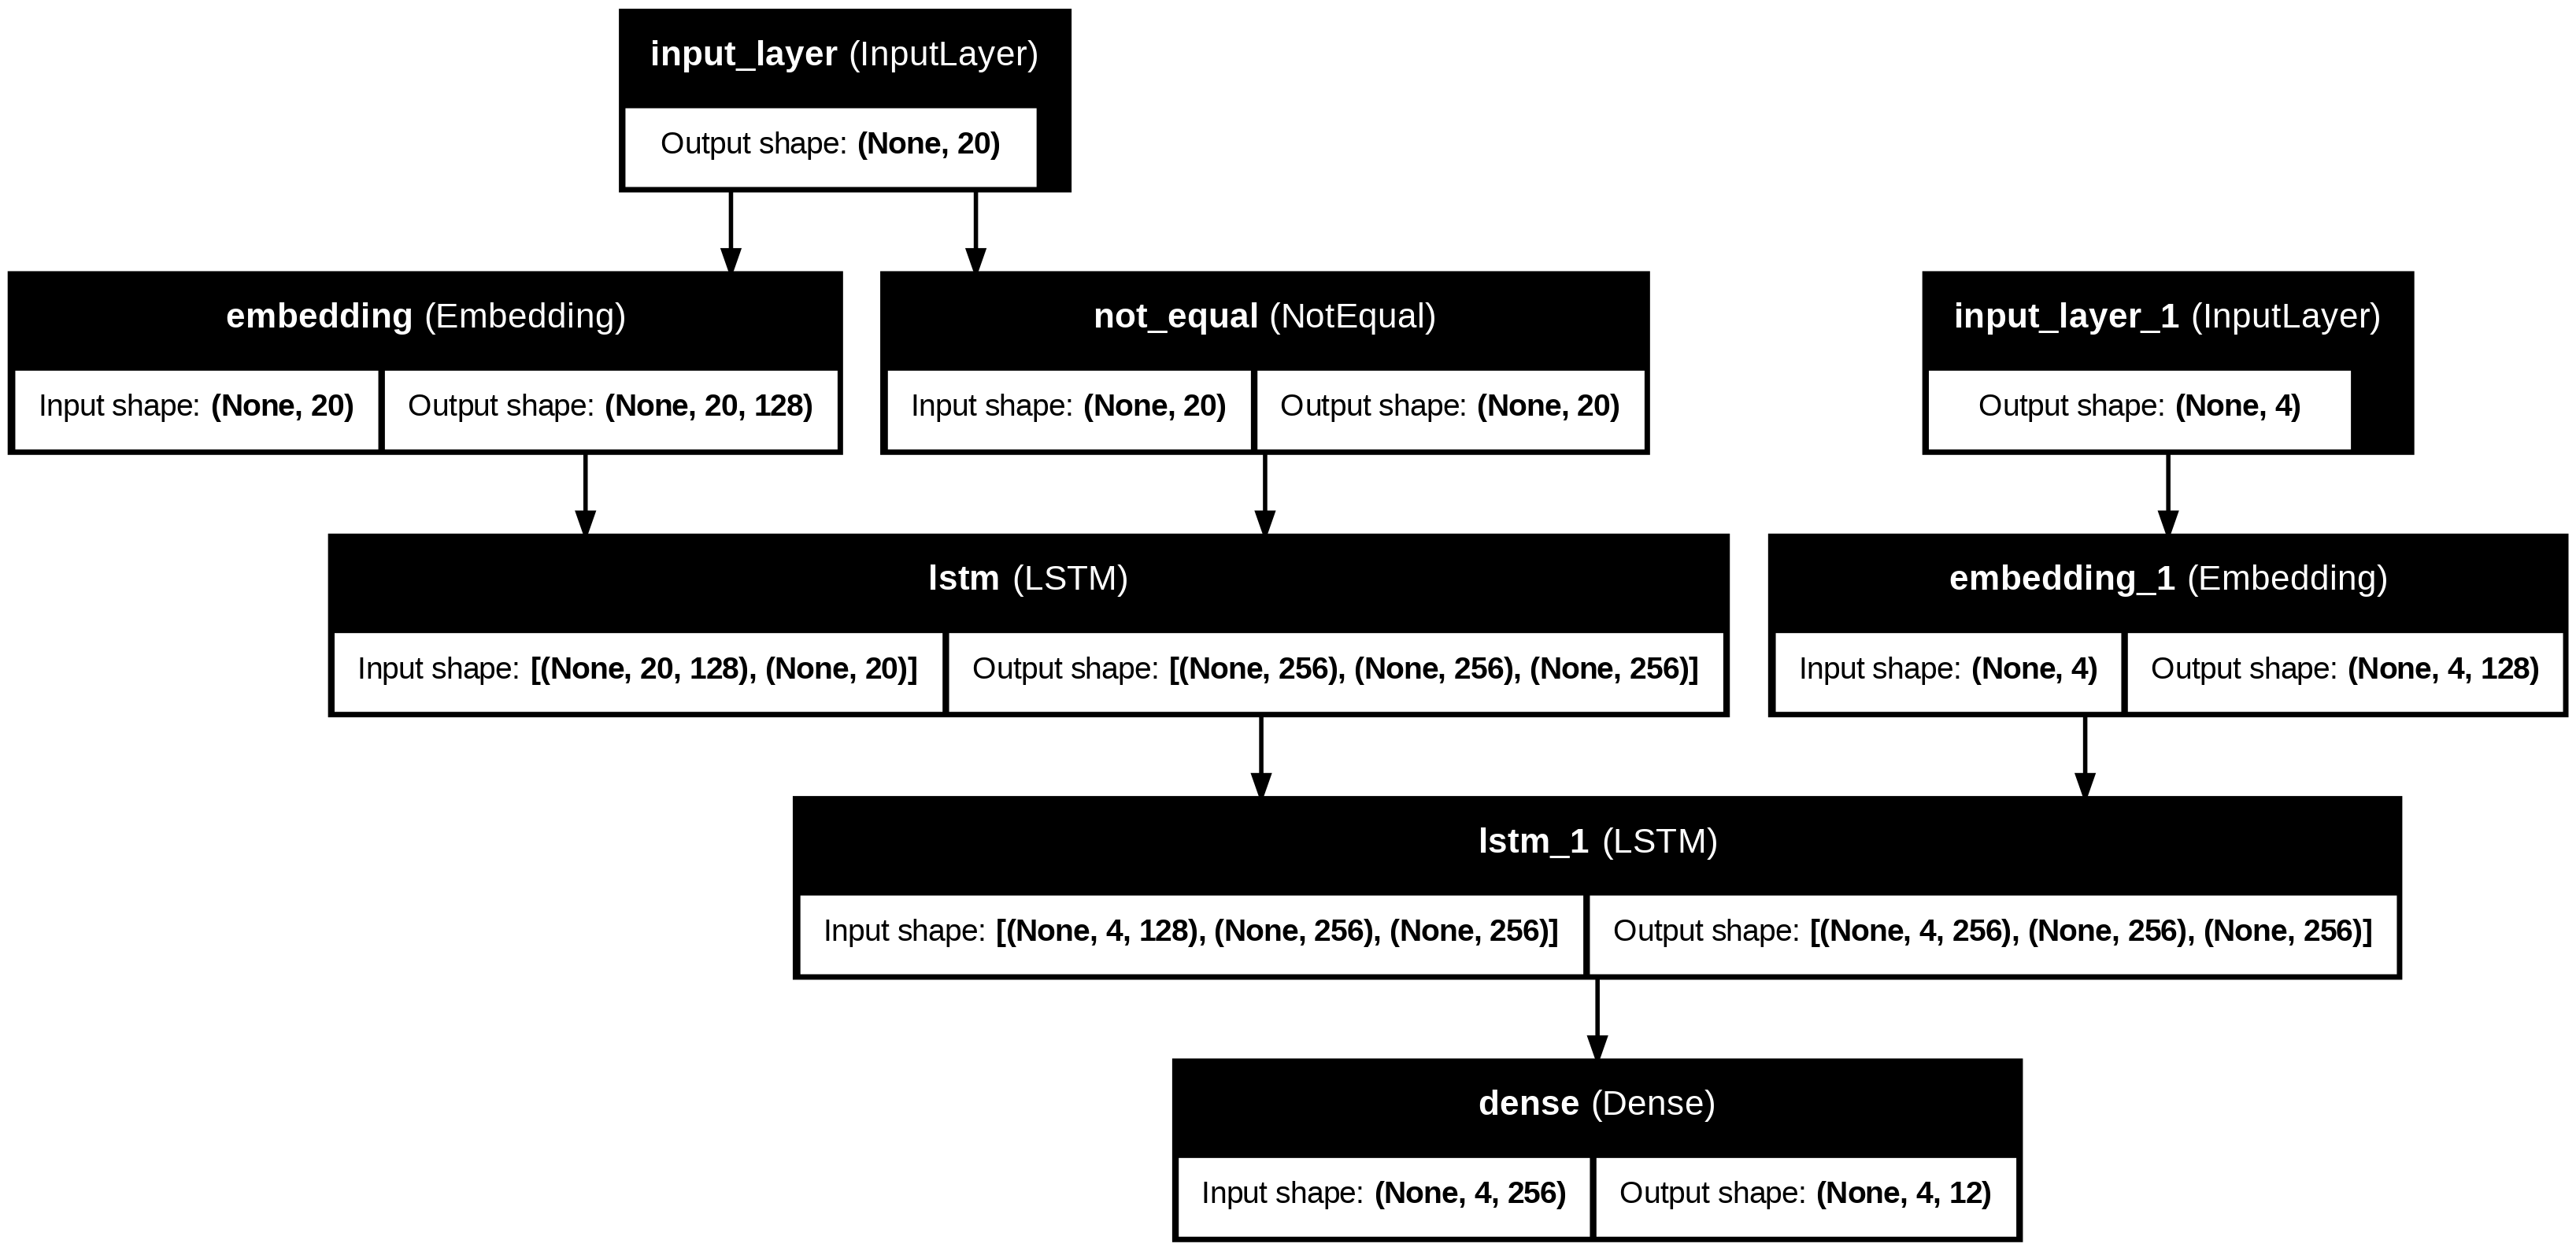

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from IPython.display import Image


# Sample text and summaries
texts = [
    "The cat sat on the mat. It was a sunny day and the cat enjoyed lying in the sun.",
    "The company announced its earnings for the quarter. Revenue increased by 20% compared to last year.",
    "The football team won the championship after a tough match. The final score was 3-2."
]

summaries = [
    "Cat enjoys the sun.",
    "Company revenue increased.",
    "Team wins championship."
]

# Hyperparameters
MAX_TEXT_LEN = 20  # Max input text length
MAX_SUMMARY_LEN = 5  # Max summary length
VOCAB_SIZE = 10000  # Vocabulary size

# Tokenizer for input texts
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
text_tokenizer.fit_on_texts(texts)
text_sequences = text_tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, maxlen=MAX_TEXT_LEN, padding='post')

# Tokenizer for summaries
summary_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
summary_tokenizer.fit_on_texts(summaries)
summary_sequences = summary_tokenizer.texts_to_sequences(summaries)
summary_padded = pad_sequences(summary_sequences, maxlen=MAX_SUMMARY_LEN, padding='post')

# Vocabulary sizes
text_vocab_size = len(text_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1

# Ensure decoder inputs and targets are correctly shaped
decoder_input_data = summary_padded[:, :-1]  # Remove last token
decoder_target_data = summary_padded[:, 1:]  # Remove first token

# Ensure consistent shape
decoder_input_data = pad_sequences(decoder_input_data, maxlen=MAX_SUMMARY_LEN-1, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, maxlen=MAX_SUMMARY_LEN-1, padding='post')

# Expand dimensions for categorical crossentropy
decoder_target_data = np.expand_dims(decoder_target_data, -1)

# Clear previous TensorFlow session to prevent conflicts
K.clear_session()

# Encoder
embedding_dim = 128
latent_dim = 256

encoder_inputs = Input(shape=(MAX_TEXT_LEN,))
encoder_embedding = Embedding(text_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(MAX_SUMMARY_LEN-1,))
decoder_embedding = Embedding(summary_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = Dense(summary_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train model
model.fit([text_padded, decoder_input_data], decoder_target_data, batch_size=32, epochs=50, verbose=1)

# Define inference model
encoder_model = Model(encoder_inputs, [state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(model, show_shapes=True,to_file='model_plot.png', show_layer_names=True, expand_nested=True)
Image('model_plot.png')




In [4]:
# Function to generate summary
def summarize(text):
    sequence = text_tokenizer.texts_to_sequences([text])
    sequence = pad_sequences(sequence, maxlen=MAX_TEXT_LEN, padding='post')

    states_value = encoder_model.predict(sequence)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = summary_tokenizer.word_index.get('<start>', 1)  # Ensure start token exists

    summary = []
    for _ in range(MAX_SUMMARY_LEN-1):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index == 0:
            break

        sampled_word = summary_tokenizer.index_word.get(sampled_token_index, '')
        summary.append(sampled_word)

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(summary)

# Test summarization
test_text = "The cat loves its cat food"
print("Summary:", summarize(test_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Summary: championship


# BART
Bidirectional Autoregressive Transformer

In [5]:
#!pip install transformers datasets torch
from transformers import BartTokenizer, BartForConditionalGeneration

# Load pre-trained BART model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Function for text summarization
def summarize(text, max_input_length=1024, max_output_length=150):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True)

    # Generate summary
    summary_ids = model.generate(inputs["input_ids"], max_length=max_output_length, num_beams=4, early_stopping=True)

    # Decode and return summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test summarization
test_text = """
President Donald Trump continued his successful Cabinet confirmation roll on Wednesday, with Tulsi Gabbard officially being approved by the Senate to become his director of national intelligence (DNI).

She became his 14th Cabinet confirmation following the 52-48 Wednesday vote. The vote was party-line, with the exception of former GOP Senate leader Mitch McConnell, R-Ky., who opposed Gabbard.

Despite an uphill battle before her first hurdle in the Senate Select Committee on Intelligence, the former Democratic representative managed to come back and get key Republicans to support her in her bid to oversee the nation's intelligence agencies.


SENATE DOGE CHAIR SAYS SHE SPEAKS WITH ELON MUSK 'EVERY FEW DAYS' AS TRUMP ADMIN SLASHES SPENDING

Mark Warner, Tulsi Gabbard, Donald Trump
Tulsi Gabbard's success came despite the impassioned plea of Vice Chairman Mark Warner, D-Va., and Democrats, who all opposed Trump's DNI pick. (Reuters)

With the coordinated and persuasive assistance of Chairman Tom Cotton, R-Ark., and Vice President JD Vance, crucial senators who had lingering concerns about Gabbard were convinced to back her in the crucial committee vote last week, including Sens. Susan Collins, R-Maine, and Todd Young, R-Ind.

Her success came despite the impassioned plea of Vice Chairman Mark Warner, D-Va., and Democrats, who all opposed Trump's DNI pick.

DEMOCRAT SENATOR BACKS TRUMP'S 'COMMON SENSE MOVE' TO FIRE THE PENNY

Tulsi Gabbard
Former Rep. Tulsi Gabbard, President Donald Trump's choice to be the Director of National Intelligence, appears before the Senate Intelligence Committee for her confirmation hearing on Capitol Hill, Thursday, Jan. 30, 2025, in Washington. (AP)

"We need leaders in the Intelligence Community and throughout government who are prepared to stand up to short-sighted attempts to attack our workforce at the expense of our national security. Unfortunately, I do not believe Ms. Gabbard is such a leader. Nor is she well-suited, by dint of experience or judgment, to serve as director of national intelligence," he explained on the chamber floor on Monday.

But Warner failed to persuade any Republicans, and Gabbard's nomination advanced past its last obstacle on Monday evening. The vote passed by a party-line margin of 52-46.

SCOOP: TRUMP BUDGET CHIEF VOUGHT TELLS GOP SENATORS $175B NEEDED 'IMMEDIATELY' FOR BORDER SECURITY

Tulsi Gabbard, Edward Snowden
Tulsi Gabbard and whistleblower Edward Snowden  (AP/Getty)

placeholder
Gabbard's Senate comeback was achieved despite concerns regarding her past meeting with former Syrian President Bashar al-Assad, her previous FISA Section 702 stance and her past support for NSA whistleblower Edward Snowden.

Trump announced his selection of Gabbard for DNI in November shortly after being elected. "I am pleased to announce that former Congresswoman, Lieutenant Colonel Tulsi Gabbard, will serve as Director of National Intelligence (DNI)," he said in a statement at the time.

NOEM, HEGSETH, BONDI PLEAD WITH CONGRESS FOR MORE BORDER FUNDING AMID LARGE-SCALE DEPORTATIONS

Donald Trump with Tulsi Gabbard
Gabbard was picked by Trump in November. (Kamil Krzaczynski/AFP via Getty Images)

CLICK HERE TO GET THE FOX NEWS APP

"For over two decades, Tulsi has fought for our Country and the Freedoms of all Americans. As a former Candidate for the Democrat Presidential Nomination, she has broad support in both Parties – She is now a proud Republican! I know Tulsi will bring the fearless spirit that has defined her illustrious career to our Intelligence Community, championing our Constitutional Rights, and securing Peace through Strength. Tulsi will make us all proud!"

Gabbard notably left the Democratic Party and subsequently endorsed Trump in the 2024 election.


"""
print("Summary:", summarize(test_text))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Summary: Tulsi Gabbard was approved by the Senate on Wednesday to become his director of national intelligence (DNI) She became his 14th Cabinet confirmation following the 52-48 Wednesday vote. The vote was party-line, with the exception of former GOP Senate leader Mitch McConnell, R-Ky., who opposed her.
